# Combined Dataset - Feed Forward Neural Network
## openSMILE GeMAPS Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import R2Score, MeanSquaredError

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

sys.path.insert(1, '../../models')
from feedforward_nn_combined import NeuralNetworkCombined

## Change featureset here!

In [2]:
featureset = NORMALISED_OPENSMILE_GEMAPS_FEATURES_CSV
featureset_path = f'{COMBINED_EXTRACTED_FEATURES_FOLDER}/scaled/{featureset}'

## Neural Network Training

### Import annotations dataset

In [3]:
df_annotations = pd.read_csv(f'{COMBINED_STATIC_ANNOTATIONS_CSV}')
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,deam_2,-0.475,-0.500
1,deam_3,-0.375,-0.425
2,deam_4,0.175,0.125
3,deam_5,-0.150,0.075
4,deam_7,0.200,0.350
...,...,...,...
2506,pmemo_993,0.525,0.725
2507,pmemo_996,0.125,0.750
2508,pmemo_997,0.325,0.425
2509,pmemo_999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [4]:
df_opensmile_gemaps = pd.read_csv(featureset_path)

df_opensmile_gemaps

,song_id,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,deam_2,0.203125,0.228950,0.176293,0.236449,0.230190,0.116627,0.089033,0.048590,0.086062,...,0.698817,0.312126,0.363082,0.600638,0.264131,0.049256,0.069750,0.164484,0.026330,0.014235
1,deam_3,0.045611,0.212611,0.047153,0.056424,0.111160,0.117979,0.057423,0.068130,0.090870,...,0.425407,0.569125,0.142183,0.581319,0.206415,0.329843,0.008219,0.024446,0.074093,0.056789
2,deam_4,0.194948,0.441883,0.092558,0.241098,0.222209,0.196694,0.233351,0.298082,0.271492,...,0.663616,0.326450,0.285985,0.606355,0.349895,0.314678,0.009789,0.018589,0.038871,0.018047
3,deam_5,0.365424,0.343558,0.239817,0.376944,0.521809,0.382685,0.134634,0.093183,0.177830,...,0.700060,0.271162,0.581293,0.384170,0.256759,0.041739,0.081478,0.149317,0.027343,0.018206
4,deam_7,0.104774,0.202851,0.072635,0.135790,0.175459,0.164417,0.059515,0.059893,0.070558,...,0.345188,0.642261,0.277318,0.575046,0.520714,0.060622,0.057195,0.142060,0.029537,0.021297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,pmemo_993,0.334791,0.619294,0.094841,0.265138,0.660498,0.695839,0.542358,0.654859,0.391566,...,0.746214,0.257190,0.342444,0.548901,0.314837,0.528696,0.003797,0.032170,0.075363,0.053774
2507,pmemo_996,0.483161,0.411218,0.255215,0.588625,0.633434,0.494025,0.265018,0.288039,0.239780,...,0.733512,0.323705,0.354431,0.644519,0.393553,0.600105,0.002546,0.007657,0.088765,0.068585
2508,pmemo_997,0.216852,0.725464,0.037013,0.089429,0.502778,0.576947,0.278887,0.457976,0.438016,...,0.766320,0.278264,0.313242,0.601849,0.338673,0.501873,0.004152,0.014067,0.080065,0.136122
2509,pmemo_999,0.330691,0.747301,0.047814,0.181547,0.757992,0.857506,0.674153,0.653097,0.251973,...,0.745425,0.294157,0.269544,0.611973,0.256421,0.604354,0.002132,0.013309,0.099848,0.200839


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [5]:
features = df_opensmile_gemaps.drop('song_id', axis=1)
features

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,0.203125,0.228950,0.176293,0.236449,0.230190,0.116627,0.089033,0.048590,0.086062,0.055174,...,0.698817,0.312126,0.363082,0.600638,0.264131,0.049256,0.069750,0.164484,0.026330,0.014235
1,0.045611,0.212611,0.047153,0.056424,0.111160,0.117979,0.057423,0.068130,0.090870,0.073441,...,0.425407,0.569125,0.142183,0.581319,0.206415,0.329843,0.008219,0.024446,0.074093,0.056789
2,0.194948,0.441883,0.092558,0.241098,0.222209,0.196694,0.233351,0.298082,0.271492,0.247961,...,0.663616,0.326450,0.285985,0.606355,0.349895,0.314678,0.009789,0.018589,0.038871,0.018047
3,0.365424,0.343558,0.239817,0.376944,0.521809,0.382685,0.134634,0.093183,0.177830,0.122941,...,0.700060,0.271162,0.581293,0.384170,0.256759,0.041739,0.081478,0.149317,0.027343,0.018206
4,0.104774,0.202851,0.072635,0.135790,0.175459,0.164417,0.059515,0.059893,0.070558,0.105512,...,0.345188,0.642261,0.277318,0.575046,0.520714,0.060622,0.057195,0.142060,0.029537,0.021297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,0.334791,0.619294,0.094841,0.265138,0.660498,0.695839,0.542358,0.654859,0.391566,0.273089,...,0.746214,0.257190,0.342444,0.548901,0.314837,0.528696,0.003797,0.032170,0.075363,0.053774
2507,0.483161,0.411218,0.255215,0.588625,0.633434,0.494025,0.265018,0.288039,0.239780,0.150021,...,0.733512,0.323705,0.354431,0.644519,0.393553,0.600105,0.002546,0.007657,0.088765,0.068585
2508,0.216852,0.725464,0.037013,0.089429,0.502778,0.576947,0.278887,0.457976,0.438016,0.514649,...,0.766320,0.278264,0.313242,0.601849,0.338673,0.501873,0.004152,0.014067,0.080065,0.136122
2509,0.330691,0.747301,0.047814,0.181547,0.757992,0.857506,0.674153,0.653097,0.251973,0.119624,...,0.745425,0.294157,0.269544,0.611973,0.256421,0.604354,0.002132,0.013309,0.099848,0.200839


In [6]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,-0.475,-0.500
1,-0.375,-0.425
2,0.175,0.125
3,-0.150,0.075
4,0.200,0.350
...,...,...
2506,0.525,0.725
2507,0.125,0.750
2508,0.325,0.425
2509,0.550,0.750


Perform 80-20 train-test split

In [7]:
## FIXME: Rewrote the dataset as a PyTorch Dataset Class
class MusicEmoDataset(Dataset):

    def __init__(self, df_features, df_targets, train=True):
        self.features = df_features
        self.targets = df_targets

        # Train-Test Split (80/20) consisting of features and targets dataset
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.targets, test_size=0.2, random_state=42)

        if train:
            self.X, self.y = torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train.values, dtype=torch.float)
        else:
            self.X, self.y = torch.tensor(X_test.values, dtype=torch.float), torch.tensor(y_test.values, dtype=torch.float)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        if len(self.X) == len(self.y):
            return len(self.X)
        else:
            raise Exception("Size of Features and Targets do not match.")        

In [8]:
## FIXME: Instantiate DEAM datasets for Train and Test split
MusicEmo_train = MusicEmoDataset(features, targets, train=True)
MusicEmo_test = MusicEmoDataset(features, targets, train=False)
print(len(MusicEmo_train))
print(len(MusicEmo_test))

2008
503


In [9]:
## FIXME: Setup Dataloader for both splits
train_dataloader = DataLoader(MusicEmo_train, batch_size=64, shuffle=True) # batch_size=len(MusicEmo_train)
test_dataloader = DataLoader(MusicEmo_test, batch_size=32) # batch_size=len(MusicEmo_test)

In [10]:
print(len(test_dataloader))

16


Define neural network parameters and instantitate neural network

In [11]:
## FIXME: What is the purpose of defining this parameters if most of them are not being used? Removed Hidden size as a variable as it is implicitly defined via input_size

input_size = features.shape[1]
output_size = targets.shape[1]  # Output size for valence and arousal
num_epochs = 2000

print(input_size, output_size)

62 2


Set a random seed to ensure consistent initial weights of the neural network

In [12]:
# # Set the seed
# seed = 42
# torch.manual_seed(seed)

#### Training

Training loop

In [13]:
def train_one_loop(model, train_dataloader, optimiser, criterion, device):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_count = 0
    
    for batch in train_dataloader:
        # Zero gradients
        optimiser.zero_grad()

        # Unpack batch
        inputs, targets = batch
        inputs_re = inputs.to(device)
        outputs_re = targets.to(device)

        # Forward pass
        preds = model(inputs_re)

        # Calculate loss
        loss = criterion(preds, outputs_re)
        
        # Add to total losses
        train_loss += loss.item() * outputs_re.shape[0]
        train_count += outputs_re.shape[0]

        # Backward pass
        loss.backward()

        # Update weights
        optimiser.step()
    
    # Compute total training loss (RMSE)
    train_loss /= train_count
    train_rmse = math.sqrt(train_loss)

    return train_rmse # Need to check whether to return optimiser, model and criterion

In [14]:
def test_one_loop(model, test_dataloader, device="cpu"):
    # Evaluation Phase
    model.eval()

    full_preds = []
    full_outputs = []
    num_features = 0
    with torch.no_grad():
        for batch in test_dataloader:
            # Unpack batch
            inputs, targets = batch
            inputs_re = inputs.to(device)
            outputs_re = targets.to(device)

            # Capture number of features
            num_features = inputs.shape[1]

            # Forward pass
            preds = model(inputs_re)
            
            # Append outputs together
            full_preds.append(preds)
            full_outputs.append(outputs_re)

    # Combine into a single tensor for preds and outputs
    preds_tensor = torch.cat(full_preds, 0)
    outputs_tensor = torch.cat(full_outputs, 0)
    
    # Calculate Mean Squared Error
    mse_metric = MeanSquaredError(multioutput="raw_values")
    mse_metric.update(preds_tensor, outputs_tensor)
    mse = mse_metric.compute()
    print("Test MSE Metric:", mse)

    average_rmse = torch.sqrt(torch.mean(mse))
    print("Test RMSE:", average_rmse.item())

    valence_rmse = torch.sqrt(mse[0])
    print("Valence RMSE:", valence_rmse.item())

    arousal_rmse = torch.sqrt(mse[1])
    print("Arousal RMSE:", arousal_rmse.item())

    # Calculate R^2 Score
    r2_metric = R2Score(multioutput="raw_values") # can be adjusted using multioutput and num_regressors (adjusted r^2 score)
    r2_metric.update(preds_tensor, outputs_tensor)
    r2_score = r2_metric.compute()
    print(f"Test R^2 Score (Valence, Arousal): {r2_score}")

    combined_r2_score = torch.mean(r2_score)
    print(f"Test R^2 Score (combined): {combined_r2_score.item():.4f}")
    
    # Calculate Adjusted R^2 Score
    r2_metric = R2Score(multioutput="raw_values", num_regressors=num_features) # can be adjusted using multioutput and num_regressors (adjusted r^2 score)
    r2_metric.update(preds_tensor, outputs_tensor)
    adjusted_r2_score = r2_metric.compute()
    print(f"Adjusted Test R^2 Score (Valence, Arousal): {adjusted_r2_score}")

    valence_adj_r2_score = adjusted_r2_score[0]
    arousal_adj_r2_score = adjusted_r2_score[1]

    combined_adj_r2_score = torch.mean(adjusted_r2_score)
    print(f"Adjusted Test R^2 Score (combined): {combined_adj_r2_score.item():.4f}")

    return average_rmse.item(), combined_adj_r2_score.item(), valence_adj_r2_score.item(), arousal_adj_r2_score.item(), preds_tensor, outputs_tensor

In [15]:
def train_model(model_kwargs, train_dataloader, test_dataloader, num_epochs, criterion=None, optimiser=None, device="cpu"):
    # Set the seed
    torch.manual_seed(seed=42)

    model = NeuralNetworkCombined(**model_kwargs)

    if optimiser is None:
        optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
    
    if criterion is None:
        criterion = nn.MSELoss()
    
    rmse_list = []
    r2_scores_list = []
    adjusted_r2_scores_valence_list = []
    adjusted_r2_scores_arousal_list = []

    for epoch in range(num_epochs):    
        train_rmse = train_one_loop(model, train_dataloader, optimiser, criterion, device)
        test_rmse, adj_r2_score, valence_adj_r2_score, arousal_adj_r2_score, predictions, targets = test_one_loop(model, test_dataloader, device)
        
        rmse_list.append(test_rmse)
        r2_scores_list.append(adj_r2_score)
        adjusted_r2_scores_valence_list.append(valence_adj_r2_score)
        adjusted_r2_scores_arousal_list.append(arousal_adj_r2_score)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss (RMSE): {train_rmse:.4f}, Test Loss (RMSE): {test_rmse:.4f}, Adjusted Test R^2 Score: {adj_r2_score:.4f}', end="\n\n")

    print("Training completed.")
    return model, rmse_list, r2_scores_list, adjusted_r2_scores_valence_list, adjusted_r2_scores_arousal_list, predictions, targets

In [16]:
model_dict = {"input_size": input_size, "output_size":output_size, "dropout_prob":0.01}

In [17]:
trained_model, rmse_list, r2_scores_list, adjusted_r2_scores_valence_list, adjusted_r2_scores_arousal_list, predictions, targets = train_model(model_dict, train_dataloader, test_dataloader, num_epochs)

Test MSE Metric: tensor([0.0919, 0.1209])
Test RMSE: 0.32617589831352234
Valence RMSE: 0.3031936585903168
Arousal RMSE: 0.34764209389686584
Test R^2 Score (Valence, Arousal): tensor([0.1343, 0.1208])
Test R^2 Score (combined): 0.1276
Adjusted Test R^2 Score (Valence, Arousal): tensor([ 0.0124, -0.0030])
Adjusted Test R^2 Score (combined): 0.0047
Epoch 1/2000, Training Loss (RMSE): 0.3355, Test Loss (RMSE): 0.3262, Adjusted Test R^2 Score: 0.0047

Test MSE Metric: tensor([0.0728, 0.0843])
Test RMSE: 0.2802257537841797
Valence RMSE: 0.2697255611419678
Arousal RMSE: 0.2903464734554291
Test R^2 Score (Valence, Arousal): tensor([0.3149, 0.3868])
Test R^2 Score (combined): 0.3508
Adjusted Test R^2 Score (Valence, Arousal): tensor([0.2184, 0.3003])
Adjusted Test R^2 Score (combined): 0.2594
Epoch 2/2000, Training Loss (RMSE): 0.2943, Test Loss (RMSE): 0.2802, Adjusted Test R^2 Score: 0.2594

Test MSE Metric: tensor([0.0680, 0.0705])
Test RMSE: 0.26310622692108154
Valence RMSE: 0.2607216536998

## Neural Network Testing

Generating scores

In [18]:
test_rmse, adj_r2_score, valence_adj_r2_score, arousal_adj_r2_score, preds_tensor, outputs_tensor = test_one_loop(trained_model, test_dataloader)

Test MSE Metric: tensor([0.0514, 0.0570])
Test RMSE: 0.23277927935123444
Valence RMSE: 0.22671756148338318
Arousal RMSE: 0.23868709802627563
Test R^2 Score (Valence, Arousal): tensor([0.5160, 0.5856])
Test R^2 Score (combined): 0.5508
Adjusted Test R^2 Score (Valence, Arousal): tensor([0.4478, 0.5272])
Adjusted Test R^2 Score (combined): 0.4875


## Analyse relationship between epochs and r^2 score

### Plot the graph to visualise the relationship the evaluation metrics

In [19]:
num_epochs_list = [i for i in range(num_epochs)]

#### RMSE vs. num_epochs

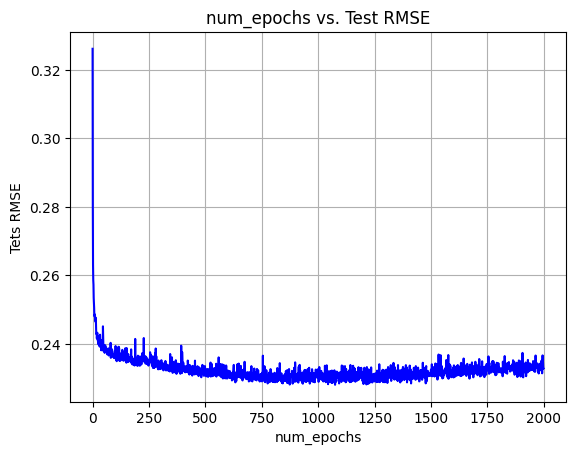

In [20]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [21]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)] + 1 

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.22802190482616425
Corresponding R^2 SCore: 0.5074564218521118
Corresponding num_epochs: 1076


Test Adjusted R^2 Score vs. num_epochs

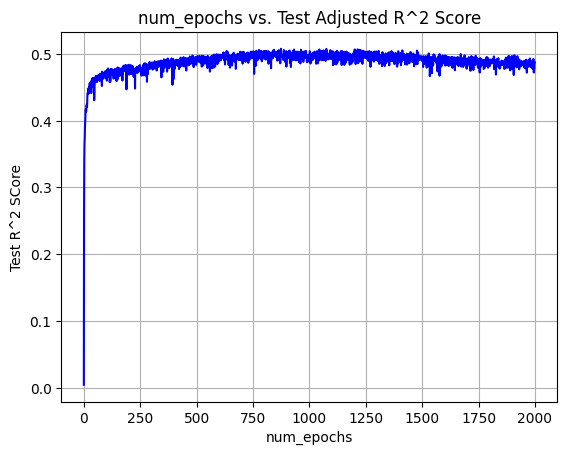

In [22]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [23]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)] + 1
optimal_num_epocs = corresponding_num_epochs

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5076510906219482
Corresponding RMSE: 0.22809240221977234
Corresponding num_epochs: 875


Test Adjusted R^2 Score (Valence) vs. num_epochs

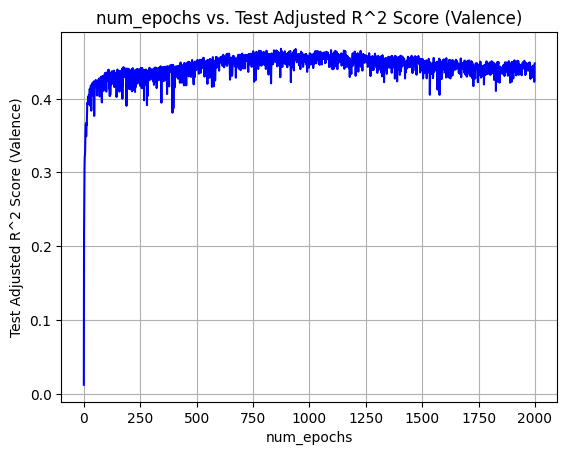

In [24]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [25]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)] + 1

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.46762603521347046
Corresponding RMSE: 0.22809240221977234
Corresponding num_epochs: 875


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

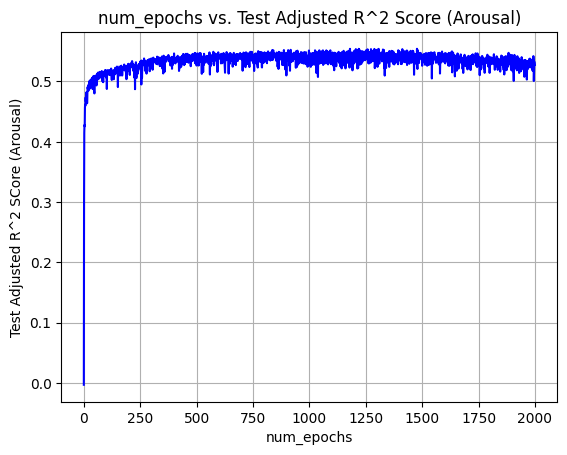

In [26]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [27]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)] + 1

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.553959310054779
Corresponding RMSE: 0.22844256460666656
Corresponding num_epochs: 1478


Getting the model with the highest test adjusted R^2 score

In [28]:
trained_model, rmse_list, r2_scores_list, adjusted_r2_scores_valence_list, adjusted_r2_scores_arousal_list, predictions, targets = train_model(model_dict, train_dataloader, test_dataloader, optimal_num_epocs)

Test MSE Metric: tensor([0.0919, 0.1209])
Test RMSE: 0.32617589831352234
Valence RMSE: 0.3031936585903168
Arousal RMSE: 0.34764209389686584
Test R^2 Score (Valence, Arousal): tensor([0.1343, 0.1208])
Test R^2 Score (combined): 0.1276
Adjusted Test R^2 Score (Valence, Arousal): tensor([ 0.0124, -0.0030])
Adjusted Test R^2 Score (combined): 0.0047
Epoch 1/875, Training Loss (RMSE): 0.3355, Test Loss (RMSE): 0.3262, Adjusted Test R^2 Score: 0.0047

Test MSE Metric: tensor([0.0728, 0.0843])
Test RMSE: 0.2802257537841797
Valence RMSE: 0.2697255611419678
Arousal RMSE: 0.2903464734554291
Test R^2 Score (Valence, Arousal): tensor([0.3149, 0.3868])
Test R^2 Score (combined): 0.3508
Adjusted Test R^2 Score (Valence, Arousal): tensor([0.2184, 0.3003])
Adjusted Test R^2 Score (combined): 0.2594
Epoch 2/875, Training Loss (RMSE): 0.2943, Test Loss (RMSE): 0.2802, Adjusted Test R^2 Score: 0.2594

Test MSE Metric: tensor([0.0680, 0.0705])
Test RMSE: 0.26310622692108154
Valence RMSE: 0.260721653699874

### Plot the predicted values vs true values

In [29]:
print(predictions)

tensor([[ 0.1930,  0.0925],
        [ 0.2473,  0.2569],
        [ 0.4373,  0.5197],
        ...,
        [ 0.1289,  0.1643],
        [-0.0652, -0.1020],
        [ 0.3777,  0.4286]])


In [30]:
print(targets)

tensor([[ 0.0500, -0.0500],
        [ 0.2500,  0.1500],
        [ 0.0250,  0.4250],
        ...,
        [ 0.4000,  0.4000],
        [ 0.0250, -0.2000],
        [ 0.6500,  0.6750]])


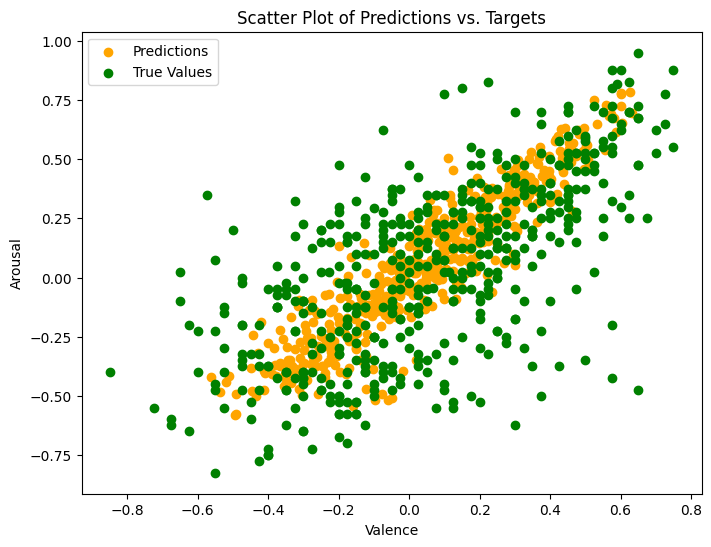

In [37]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the tensors from the predictions in orange
for tensor in predictions:
    predictions_scatter = ax.scatter(tensor[0], tensor[1], color='orange')

# Plot the tensors from the targets in green
for tensor in targets:
    targets_scatter = ax.scatter(tensor[0], tensor[1], color='green')

# Set the axis labels and title
ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
ax.set_title('Scatter Plot of Predictions vs. Targets')

# set the legend
legend_elements = [
    predictions_scatter,
    targets_scatter
]
ax.legend(legend_elements, ['Predictions', 'True Values'], loc='upper left')

# Show the plot
plt.show()

### Save the model weights

In [32]:
# torch.save(trained_model.state_dict(), f'../../models/opensmile_gemaps_normalised/combined_feedforward_nn_opensmile_gemaps_normalised.pt')